### Very Simple Example (single reaction)

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import solve_ivp, odeint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [2]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]  # Initial conditions
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1,k2))

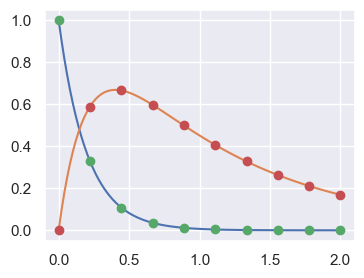

In [3]:
# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))

# Create true data
t_true = torch.from_numpy(t).float().view(-1,1).to(DEVICE)
y_true = torch.from_numpy(solution).float().to(DEVICE)

# Make training data
n_samples = 10
t_train = torch.linspace(T_START, 2, n_samples).view(-1,1).requires_grad_(True).to(DEVICE)
y_train_1 = z_1(t_train.cpu().detach().numpy())
y_train_2 = z_2(t_train.cpu().detach().numpy())
# Stack the two solutions using numpy 
y_train = np.hstack((y_train_1, y_train_2))

# Plot true and training data 
plt.figure(figsize=(4,3))
plt.plot(t_true.cpu().numpy(), y_true .cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_train[:,0], 'o')
plt.plot(t_train.cpu().detach().numpy(), y_train[:,1], 'o')
plt.show()

In [4]:
# Make a NN for u
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 10)
        self.fc3 = nn.Linear(10, 2)
        
        self.k2 = nn.Parameter(torch.tensor([1.0]))
        self.k1 = nn.Parameter(torch.tensor([1.0]))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)
us_train = torch.tensor(y_train, requires_grad=True).float().to(DEVICE)

/tmp/ipykernel_5484/3687197062.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)


In [6]:
def residuals(t, model: nn.Module):
    t = torch.linspace(T_START, T_END, 500).view(-1,1).to(DEVICE)
    t.requires_grad = True  
    u = model(t).to(DEVICE)
    u_t_1  = torch.autograd.grad(u[:,0], t, grad_outputs=torch.ones_like(u[:,0]), create_graph=True)[0]
    u_t_2  = torch.autograd.grad(u[:,1], t, grad_outputs=torch.ones_like(u[:,1]), create_graph=True)[0]
    error_1 = u_t_1 - (-model.k1 * u[:,0])
    error_2 = u_t_2 - (model.k1 * u[:,0] - model.k2 * u[:,1])
    e_1 = torch.mean(error_1)
    e_2 = torch.mean(error_2)
    return e_1**2+e_2**2

In [11]:
network = Network().to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    
    u_pred = network.forward(ts_train)
    residual_pred = residuals(ts_train, network)
    
    loss = criterion(u_pred, us_train)
    loss += torch.mean(residual_pred**2)
    
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}] Loss: {loss}, k1: {network.k1.item()}, k2: {network.k2.item()}')
        

Epoch [0/10000] Loss: 0.19621647894382477, k1: 0.9990000128746033, k2: 0.9990000128746033
Epoch [500/10000] Loss: 0.027373092249035835, k1: 1.1534264087677002, k2: 0.740105926990509
Epoch [1000/10000] Loss: 0.004876542836427689, k1: 1.4908316135406494, k2: 0.48580247163772583
Epoch [1500/10000] Loss: 0.002357513876631856, k1: 1.826412558555603, k2: 0.3856157660484314
Epoch [2000/10000] Loss: 0.0015400496777147055, k1: 2.1201956272125244, k2: 0.4456118047237396
Epoch [2500/10000] Loss: 0.0010272882645949721, k1: 2.391451358795166, k2: 0.5212114453315735
Epoch [3000/10000] Loss: 0.0006943057524040341, k1: 2.6438066959381104, k2: 0.5848648548126221
Epoch [3500/10000] Loss: 0.00047091758460737765, k1: 2.8780577182769775, k2: 0.637063205242157
Epoch [4000/10000] Loss: 0.0003175875172019005, k1: 3.0951621532440186, k2: 0.6809317469596863
Epoch [4500/10000] Loss: 0.00021177524467930198, k1: 3.2961199283599854, k2: 0.718829333782196
Epoch [5000/10000] Loss: 0.00013928141561336815, k1: 3.481616

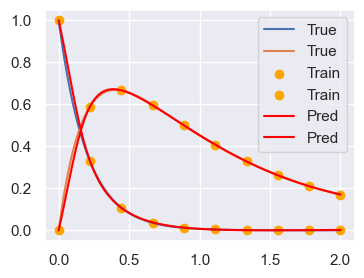

In [12]:
# Plot u_pred vs ts
network.eval()
with torch.no_grad():
    u_pred = network(t_true)
    plt.figure(figsize=(4,3))
    plt.plot(t_true.cpu(), y_true.cpu(), label='True')
    plt.scatter(t_train.cpu(), y_train[:,0], label='Train', color='orange')
    plt.scatter(t_train.cpu(), y_train[:,1], label='Train', color='orange')
    plt.plot(t_true.cpu(), u_pred[:,0].cpu().numpy(), label='Pred', color='red')
    plt.plot(t_true.cpu(), u_pred[:,1].cpu().numpy(), label='Pred', color='red')
    plt.legend()
    plt.show()

In [13]:
network.k1, network.k2

(Parameter containing:
 tensor([4.5407], requires_grad=True),
 Parameter containing:
 tensor([0.9381], requires_grad=True))

In [14]:
1/0

ZeroDivisionError: division by zero

### Simple Regression

In [ ]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]  # Initial conditions
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1,k2))

# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))
 
t_train = np.linspace(T_START, T_END, 10)  
y_train = np.column_stack((z_1(t_train), z_2(t_train)))

# Plot true and training data
plt.figure(figsize=(4,3))
plt.plot(t, solution, label=['y1','y2'])
plt.scatter(x=t_train, y=y_train[:,0], label='y1_exp')
plt.scatter(x=t_train, y=y_train[:,1], label='y2_exp')
plt.legend()
plt.show()

## Parameter estimation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import curve_fit

import scipy.stats as stats

In [ ]:
#Performs the dot produt to make the model 
def MakeModel(MatrixCoeficients,InitialConditions):
    return np.dot(MatrixCoeficients,InitialConditions)

In [ ]:
# ODE system  solving  

SolverTime=np.linspace(0,20,num=120)

# Model Parameters
k1=0.3
k2=0.25
k3=0.1

#Coeficients matrix for model 
def MakeModelMatrix02(K1,K2,K3):
    Matrix=np.zeros((3,3))
    Matrix[0,0]=-K1
    Matrix[0,1]=K3
    Matrix[1,0]=K1
    Matrix[1,1]=-(K2+K3)
    Matrix[2,1]=K2
    return Matrix

Matrix02=MakeModelMatrix02(k1,k2,k3)
InitialConditions=[5,0,0]

def KineticsSystem(InitialConditions,t):
    return MakeModel(Matrix02,InitialConditions)

SystemSolution=odeint(KineticsSystem,InitialConditions,SolverTime)

In [ ]:
plt.figure(3,figsize=(9,6))

plt.plot(SolverTime,SystemSolution[:,0],'b-',label='[A]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,SystemSolution[:,1],'g-',label='[B]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,SystemSolution[:,2],'m-',label='[C]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
plt.show()

In [ ]:
# Data Generation
#Element wise sum of two iterables of the same size, name makes reference to the output rather than the process
def MakeNoisyData(Data,Noise):
    return [val+cal for val,cal in zip(Data,Noise)]

WhiteNoise=[np.random.uniform(low=-1,high=1)/4 for val in SystemSolution[:,2]]
WhiteSignal=MakeNoisyData(SystemSolution[:,2],WhiteNoise)

In [ ]:
###############################################################################
#                              ODE fitting  
###############################################################################

def ModelSolver02(t,K1,K2,K3,InitialConditions):
    
    cK1=K1
    cK2=K2
    cK3=K3
    
    cInit=InitialConditions
    
    cMatrix=MakeModelMatrix02(cK1,cK2,cK3)
    
    def LocalModel(cInit,t):
        
        return MakeModel(cMatrix,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,2]

def ModelSolution02(t,K1,K2,K3):
    
    return ModelSolver02(t,K1,K2,K3,InitialConditions)
    
    
Model02Params=curve_fit(ModelSolution02,SolverTime,WhiteSignal)

fK1=Model02Params[0][0]
fK2=Model02Params[0][1]
fK3=Model02Params[0][2]

FitSolutionB=ModelSolution02(SolverTime,fK1,fK2,fK3)

###############################################################################
#                        Visualization
###############################################################################

plt.figure(4,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(SolverTime, WhiteSignal,bottom=0,label='Data',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )

SolutionLabel='[C]'
plt.plot(SolverTime,FitSolutionB,'m-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    
plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.ylim(0,5.2)

ax=plt.gca()
plt.show()

###############################################################################
#                    Residuals Statistical test  
###############################################################################

ObRes=[signal-model for signal,model in zip(WhiteSignal,FitSolutionB)]

KS=stats.ks_2samp(ObRes,WhiteNoise)

print(KS)